# Titanic Survival Competition

In [96]:
#Data Analysis and Handling
import pandas as pd
import numpy as np
import random as rnd

#Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#Show Warnings Only Once
import warnings
warnings.filterwarnings('once')

#Machine Learning Libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

import keras
from keras.models import Sequential
from keras.layers import Dense

#Constants
LABELS = ["Survived", "Died"]
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5]

# Preprocessing & Exploration

In [2]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Sage, Master. Thomas Henry",male,1601,G6,S
freq,1,577,7,4,644


In [6]:
train[['Embarked', "Survived"]].groupby(['Embarked']).mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


In [7]:
train[['Pclass', "Survived"]].groupby(['Pclass']).mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [8]:
train[['Sex', "Survived"]].groupby(['Sex']).mean()

,Survived
Sex,
female,0.742038
male,0.188908


In [9]:
train[['SibSp', "Survived"]].groupby(['SibSp']).mean()

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


In [10]:
train[['Parch', "Survived"]].groupby(['Parch']).mean()

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


From examining the categorical features of the dataset we can see that passenger class and sex seem to have a significant correlation with survival. While we can't rule out the other categorical variables the aforementioned two categories seem to be the most promising.

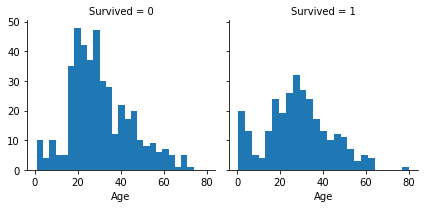

In [11]:
age = sns.FacetGrid(train, col='Survived')
age.map(plt.hist, 'Age', bins=25)

From the historgram we can observe that the highest survival rates occur in young children and those of age 20-40. Interestingly, the highest mortality rate also occurs in the 20-40 year age range - suspect this has something to do with gender or passenger class.

In [12]:
#Drop Ticket Number and Cabin Number - these fields are assumed have no correlation to survival rate
train = train.drop(['Ticket', 'Cabin'], axis = 1)
test = test.drop(['Ticket', 'Cabin'], axis = 1)
combined = [train, test]

In [13]:
#Feature Extraction - Titles
for dataset in combined:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

for dataset in combined:
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',
                                                  'Don', 'Dr', 'Major', 'Rev', 'Sir', 
                                                  'Jonkheer', 'Dona'], 'Other')
#Convert Categorical to Numerical
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Other": 5}

for dataset in combined:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

#Drop Name and PassengerId
train = train.drop(['Name','PassengerId'], axis=1)
test = test.drop(['Name'], axis=1)
combined = [train, test]
    
train.head()

<>:3: DeprecationWarning: invalid escape sequence \.


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,1
1,1,1,female,38.0,1,0,71.2833,C,3
2,1,3,female,26.0,0,0,7.9250,S,2
3,1,1,female,35.0,1,0,53.1000,S,3
4,0,3,male,35.0,0,0,8.0500,S,1


In [14]:
train.shape, test.shape

((891, 9), (418, 9))

In [15]:
#Label Categorical Features
for dataset in combined:
    dataset['Sex'] = dataset['Sex'].map({'female':0, 'male':0}).astype(int)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,0,38.0,1,0,71.2833,C,3
2,1,3,0,26.0,0,0,7.9250,S,2
3,1,1,0,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


In [16]:
#Drop NaN rows for Age
train = train.dropna(axis='index',how='any')
test = test.dropna(axis='index',how='any')
    
train.shape, test.shape

((712, 9), (331, 9))

In [17]:
#Find Age Bands
train['AgeBand'] = pd.cut(train['Age'],5)
train[['AgeBand', 'Survived']].groupby(['AgeBand']).mean().sort_values(by='AgeBand', ascending=True)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Survived
AgeBand,
"(0.34, 16.336]",0.550000
"(16.336, 32.252]",0.369942
"(32.252, 48.168]",0.401070
"(48.168, 64.084]",0.426471
"(64.084, 80.0]",0.090909


In [18]:
combined = [train, test]

#Bin Age Variable
for dataset in combined:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
    
train = train.drop(['AgeBand'],axis=1)
combined = [train,test]

train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1.0,1,0,7.2500,S,1
1,1,1,0,2.0,1,0,71.2833,C,3
2,1,3,0,1.0,0,0,7.9250,S,2
3,1,1,0,2.0,1,0,53.1000,S,3
4,0,3,0,2.0,0,0,8.0500,S,1


In [19]:
#Create FamilySize and IsAlone Variable from SibSp and Parch
for dataset in combined:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in combined:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone
0,0,3,0,1.0,1,0,7.2500,S,1,2,0
1,1,1,0,2.0,1,0,71.2833,C,3,2,0
2,1,3,0,1.0,0,0,7.9250,S,2,1,1
3,1,1,0,2.0,1,0,53.1000,S,3,2,0
4,0,3,0,2.0,0,0,8.0500,S,1,1,1


In [20]:
#Evaluate FamilySize
train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean()

,FamilySize,Survived
0,1,0.318408
1,2,0.546763
2,3,0.569892
3,4,0.777778
4,5,0.272727
5,6,0.136364
6,7,0.333333
7,8,0.000000


In [21]:
#Evaluate IsAlone
train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.516129
1,1,0.318408


In [22]:
#Drop Columns
train = train.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test = test.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combined = [train, test]

train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1.0,7.2500,S,1,0
1,1,1,0,2.0,71.2833,C,3,0
2,1,3,0,1.0,7.9250,S,2,1
3,1,1,0,2.0,53.1000,S,3,0
4,0,3,0,2.0,8.0500,S,1,1


In [23]:
#Impute Values of Embarked with Most Frequent Value then Convert Categorical to Numeric
impute_val = train.Embarked.dropna().mode()

for dataset in combined:
    dataset['Embarked'] = dataset['Embarked'].fillna(impute_val)
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [24]:
#Find Suitable Bins for Fare
train['FareBand'] = pd.qcut(train['Fare'], 4)
train[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 8.05]",0.204188
1,"(8.05, 15.646]",0.321212
2,"(15.646, 33.0]",0.486034
3,"(33.0, 512.329]",0.615819


In [25]:
#Bin Fare Variable
for dataset in combined:
    dataset.loc[ dataset['Fare'] <= 8.05, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 8.05) & (dataset['Fare'] <= 15.646), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 15.646) & (dataset['Fare'] <= 33), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 33, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train = train.drop(['FareBand'], axis=1)
combined = [train, test]
    
train.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1.0,0,0,1,0
1,1,1,0,2.0,3,1,3,0
2,1,3,0,1.0,0,0,2,1
3,1,1,0,2.0,3,0,3,0
4,0,3,0,2.0,0,0,1,1
6,0,1,0,3.0,3,0,1,1
7,0,3,0,0.0,2,0,4,0
8,1,3,0,1.0,1,0,3,0
9,1,2,0,0.0,2,1,3,0
10,1,3,0,0.0,2,0,2,0


In [39]:
X_train = train.iloc[:,1:]
X_test = test.iloc[:,1:]

Y_train = train["Survived"]

## Logistic Regression - LASSO (L1 Penalty)

In [42]:
#Fit model using Logistic Regression with L1 penalty (5-fold CV)
clf_l1 = LogisticRegressionCV(Cs=alphas, cv = 5, penalty = "l1", solver = 'liblinear').fit(X_train, Y_train)

#Predict
pred_train_l1 = clf_l1.predict(X_train)
pred_test_l1 = clf_l1.predict(X_test)

Text(0.5, 1.0, 'Confusion Matrix for Training Set')

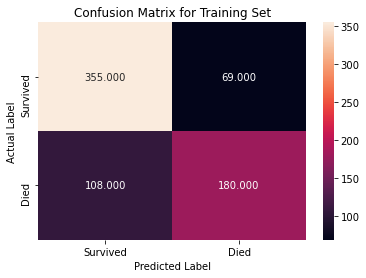

In [50]:
#Confusion Matrix
confusion_train_l1 = confusion_matrix(Y_train, pred_train_l1)
sns.heatmap(confusion_train_l1, annot=True, fmt= ".3f", xticklabels = LABELS, yticklabels = LABELS)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix for Training Set")

In [59]:
acc_L1 = round(clf_l1.score(X_train,Y_train)*100, 2)
print("Training Accuracy for L1 Penalized Logistic Regression = " + str(acc_L1))

Training Accuracy for L1 Penalized Logistic Regression = 75.14


## Logistic Regression - Ridge (L2 Penalty)

In [62]:
#Fit model using Ridge Classifier (5-fold CV)
clf_l2 = RidgeClassifierCV(alphas=alphas, cv = 5).fit(X_train, Y_train)

#Predict
pred_train_l2 = clf_l2.predict(X_train)
pred_test_l2 = clf_l2.predict(X_test)

Text(0.5, 1.0, 'Confusion Matrix for Training Set')

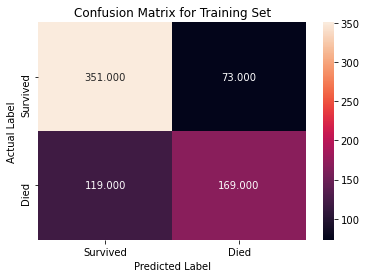

In [56]:
#Confusion Matrix
confusion_train_l2 = confusion_matrix(Y_train, pred_train_l2)
sns.heatmap(confusion_train_l2, annot=True, fmt= ".3f", xticklabels = LABELS, yticklabels = LABELS)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix for Training Set")

In [58]:
acc_L2 = round(clf_l2.score(X_train,Y_train)*100, 2)
print("Training Accuracy for L2 Penalized Logistic Regression = " + str(acc_L2))

Training Accuracy for L2 Penalized Logistic Regression = 73.03


## Support Vector Machine

In [69]:
lin_svc = LinearSVC(dual=False ,max_iter=500000)
params = {'penalty':['l1','l2'],'C':alphas}
clf_svc = GridSearchCV(estimator=lin_svc, param_grid=params, cv=5)
clf_svc.fit(X_train,Y_train)
pred_train_svc = clf_svc.predict(X_train)
pred_test_svc = clf_svc.predict(X_test)

Text(0.5, 1.0, 'Confusion Matrix for Training Set')

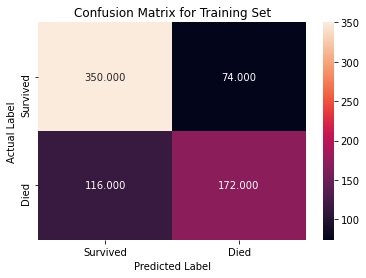

In [70]:
#Confusion Matrix
confusion_train_svc = confusion_matrix(Y_train, pred_train_svc)
sns.heatmap(confusion_train_svc, annot=True, fmt= ".3f", xticklabels = LABELS, yticklabels = LABELS)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix for Training Set")

In [71]:
acc_svc = round(clf_svc.score(X_train,Y_train)*100, 2)
print("Training Accuracy for Support Vector Classifier = " + str(acc_svc))

Training Accuracy for Support Vector Classifier = 73.31


## Random Forest Classifier

In [74]:
#Fit Model
clf_rf = RandomForestClassifier().fit(X_train, Y_train)

#Predict
pred_train_rf = clf_rf.predict(X_train)
pred_test_rf = clf_rf.predict(X_test)

Text(0.5, 1.0, 'Confusion Matrix for Training Set')

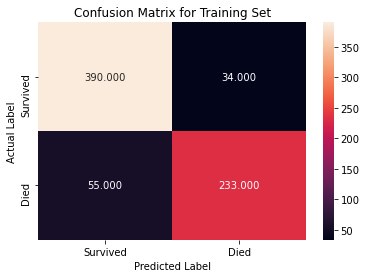

In [76]:
#Generate Confusion Matrix
confusion_train_rf = confusion_matrix(Y_train, pred_train_rf)
sns.heatmap(confusion_train_rf, annot=True, fmt= ".3f", xticklabels = LABELS, yticklabels = LABELS)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix for Training Set")

In [77]:
acc_rf = round(clf_rf.score(X_train,Y_train)*100, 2)
print("Training Accuracy for Random Forest Classifier = " + str(acc_rf))

Training Accuracy for Support Vector Classifier = 87.5


## Extra Trees Classifier


In [78]:
#Fit Model
clf_et = ExtraTreesClassifier().fit(X_train, Y_train)

#Predict
pred_train_et = clf_et.predict(X_train)
pred_test_et = clf_et.predict(X_test)

Text(0.5, 1.0, 'Confusion Matrix for Training Set')

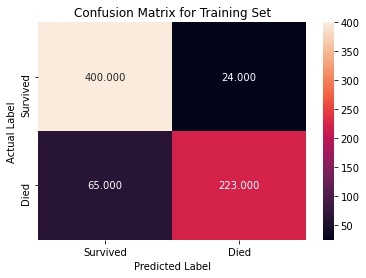

In [79]:
#Generate Confusion Matrix
confusion_train_et = confusion_matrix(Y_train, pred_train_et)
sns.heatmap(confusion_train_et, annot=True, fmt= ".3f", xticklabels = LABELS, yticklabels = LABELS)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix for Training Set")

In [80]:
acc_et = round(clf_et.score(X_train,Y_train)*100, 2)
print("Training Accuracy for Extra Trees Classifier = " + str(acc_et))

Training Accuracy for Extra Trees Classifier = 87.5


## Neural Network

In [89]:
#Build Model
model = Sequential()
model.add(Dense(64, input_dim=len(X_train.columns), activation='relu'))

model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#Compile Model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [90]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________


In [98]:
#Fit Model
model.fit(X_train, Y_train, epochs=100, batch_size=10)

#Predict
pred_train_nn = model.predict_classes(X_train)
pred_test_nn = model.predict_classes(X_test)

Epoch 1/100
712/712 [==============================] - 0s 176us/step - loss: 0.3613 - accuracy: 0.8413
Epoch 2/100
712/712 [==============================] - 0s 160us/step - loss: 0.3534 - accuracy: 0.8539
Epoch 3/100
712/712 [==============================] - 0s 161us/step - loss: 0.3497 - accuracy: 0.8525
Epoch 4/100
712/712 [==============================] - 0s 171us/step - loss: 0.3423 - accuracy: 0.8511
Epoch 5/100
712/712 [==============================] - 0s 178us/step - loss: 0.3479 - accuracy: 0.8638
Epoch 6/100
712/712 [==============================] - 0s 164us/step - loss: 0.3426 - accuracy: 0.8553
Epoch 7/100
712/712 [==============================] - 0s 157us/step - loss: 0.3450 - accuracy: 0.8525
Epoch 8/100
712/712 [==============================] - 0s 158us/step - loss: 0.3536 - accuracy: 0.8483
Epoch 9/100
712/712 [==============================] - 0s 199us/step - loss: 0.3430 - accuracy: 0.8483
Epoch 10/100
712/712 [==============================] - 0s 189us/step - l

712/712 [==============================] - 0s 182us/step - loss: 0.3252 - accuracy: 0.8539
Epoch 80/100
712/712 [==============================] - 0s 161us/step - loss: 0.3225 - accuracy: 0.8624
Epoch 81/100
712/712 [==============================] - 0s 189us/step - loss: 0.3189 - accuracy: 0.8567
Epoch 82/100
712/712 [==============================] - 0s 193us/step - loss: 0.3141 - accuracy: 0.8708
Epoch 83/100
712/712 [==============================] - 0s 174us/step - loss: 0.3144 - accuracy: 0.8581
Epoch 84/100
712/712 [==============================] - 0s 182us/step - loss: 0.3257 - accuracy: 0.8624
Epoch 85/100
712/712 [==============================] - 0s 168us/step - loss: 0.3180 - accuracy: 0.8652
Epoch 86/100
712/712 [==============================] - 0s 181us/step - loss: 0.3220 - accuracy: 0.8553
Epoch 87/100
712/712 [==============================] - 0s 160us/step - loss: 0.3302 - accuracy: 0.8610
Epoch 88/100
712/712 [==============================] - 0s 181us/step - loss:

Text(0.5, 1.0, 'Confusion Matrix for Training Set')

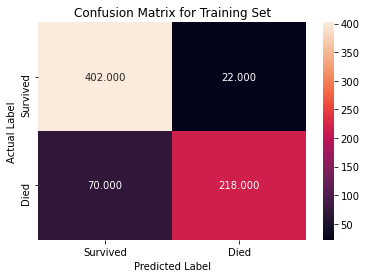

In [99]:
#Generate Confusion Matrix
confusion_train_nn = confusion_matrix(Y_train, pred_train_nn)
sns.heatmap(confusion_train_nn, annot=True, fmt= ".3f", xticklabels = LABELS, yticklabels = LABELS)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix for Training Set")

In [101]:
acc_nn = accuracy_score(Y_train, pred_train_nn)
print("Accuracy Neural Network = " + str(acc_nn))

Accuracy Neural Network = 0.8707865168539326
